# 第9回 モデルの検証方法とチューニング方法

＜章トビラ＞

教師あり学習によって構築されるモデルは、未知のデータに適用したときに、モデル構築者の期待する性能を発揮することが重要です。8章では、この未知のデータに対するモデル性能（汎化性能）を評価するためのモデルの検証方法を学びます。さらに、そもそものモデルの汎化性能を向上させるためのアプローチについても学びます。

ゴール：モデル構築時の注意点や評価方法を学び、評価指標を計算することができる。複数のモデルを組み合わせるアンサンブル学習を理解し、代表的手法を使えるようになる。

## 1 モデルの評価と精度を上げる方法とは

ゴール：モデルを構築するときの注意点や検証方法の概要を知る


機械学習というものは、学習のさせ方やモデルの選び方やパラメータ、学習させるデータ数などによって、その結果が大きく異なります。精度を高めるにはモデルのチューニングが不可欠です。たとえば、学習させるデータが足りないときは、水増しして学習させると良い結果が得られることもあります。
この章ではモデルの良し悪しの判断や、モデルのチューニング方法について説明します。

### 1.1 機械学習の課題とアプローチ

この章では、機械学習を利用する際に生じるさまざまな課題と解決のためのアプローチについて説明します。

#### ①新しいデータに適合できない場合

モデルの作り方や学習のさせ方によっては、現在のデータにあてはまりすぎて、新しいデータでは良い結果が得られないことがあります。このような状態を**オーバーフィッティング（過学習、もしくは過剰学習）**といいます。それを防ぐために、あらかじめ学習用のデータからテスト用としてデータを抜き出しておく**ホールドアウト法**や**交差検証法**があります。

#### ②モデルの良さを判定する指標や方法とは

モデルの良さを判定するには実は色々な指標があります。今まで、モデルの予測精度や良さという話をしてきましたが、そもそも予測精度とは一体なんでしょうか。単にモデルがうまく予測できたからといって、手放しで喜んでいいわけではありません。
予測精度を測るための概念として、**混同行列**や**ROC曲線**があります。

#### ③精度が高いモデルを作成するには

既に、決定木やロジスティック回帰など、さまざまな教師あり学習の予測モデルを個別に学びました。これらのモデルを単独で使うのではなく、複数のモデルを組み合わせる**アンサンブル学習**と呼ばれる方法もあります。アンサンブル学習では、個々の学習結果を組み合わせて、複数の結果で評価します。具体的な手法として、**バギング、ブースティング**などがあります。これらの方法を使うことで、モデルの精度を高めることが可能になります。



### 1.2 この章で使うライブラリのインポート

この章では、既に勉強したNumpyやPandasなどの各種ライブラリのほかに、機械学習ライブラリのScikit-learnを使います。次のようにインポートしていることを前提として進めていきます。

In [ ]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series,DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
sns.set()

# 機械学習ライブラリ
import sklearn

# 小数第3位まで表示
%precision 3

'%.3f'

## 2 モデルの評価とパフォーマンスチューニング
ゴール：機械学習モデルの汎化性能の評価方法と、そもそもの性能を高めるためのアプローチを理解する。

前回は、データを学習用とテスト用に分けてモデルを構築・検証しました。このようにモデルの学習に使用しないデータを準備し、モデル性能を確認するという手順はとても大切です。なぜなら、機械学習モデルは、現在保有しているデータに対して高い説明力を持つためだけではなく、将来発生するであろう未知のデータに対しても、同様に高い予測性能（汎化性能）を発揮することが期待されるからです。

先に述べたように、学習に用いたデータには当てはまるが、未知のデータには当てはまらない状態をオーバーフィッティング（過学習、もしくは過剰学習）といいます。本節では、オーバーフィッティングが生じていないかの判断方法や、モデルの汎化性能を適切に評価するための方法について学びます。

この節では、**ホールドアウト法（holdout method）**と**交差検証法（cross validation）**を扱います。交差検証法については、**k分割交差検証（k-fold法）**と**1個抜き交差検証（leave-one-out）**を紹介します。また汎化性能を高めるための特徴量の扱い方や、アルゴリズムが固有に持つパラメータのチューニング方法についても学びます。前者は**特徴量エンジニアリング（feature engineering）**や**次元削減（dimension reduction）**、後者は**ハイパーパラメータチューニング（hyperparameter tuning）**と呼ばれる技術領域です。

### 2.1 ホールドアウト法と交差検証法
キーワード：過学習（過剰学習）、ホールドアウト法、交差検証法、k分割交差検証法

**ホールドアウト法（holdout method）**とは、教師あり学習のモデル構築の回ですでにやってきたように、データを学習データとテストデータの2つにランダムに分割し、学習用データでモデルを構築し、その後、テスト用データでモデルを検証する方法です。

教師あり学習モデルでは、高い汎化性能の獲得が期待されます。そこで学習データを既知のデータとみなし、テストデータを未知のデータとみなすことで、その未知のデータにおける性能を評価するというのがホールドアウト法です。ホールドアウト法は非常にシンプルですが、データ数が十分大きい時には、モデルの評価方法として実用的に使えます。しかしデータ数が限られるときは、2つの問題が生じます。ひとつは、ランダムに分割された特定のテストデータによっては、たまたま高く評価されてしまう問題です。もうひとつは、限られたデータを学習用とテスト用に分割するため、学習データ数が削られ、肝心の学習が十分に進まないという問題です。

そこで、限られたデータを最大限に活用しようと考案されたのが**交差検証法（cross validation）**です。これはデータの役割を学習用と検証用に交差させる検証法です。交差検証法の代表的な手法に**k分割交差検証（k-fold cross validation）**があります。この手法では、データをk個のブロックにランダムに分割します。そして、k個のうち1つのブロックを検証用、残りの$k-1$個を学習用として活用します。

k分割交差検証のイメージは下図の通りです。ここでは$k=5$の場合を例示しています。データはまず、ランダムに5個のデータグループに分割されます。そのうち4個のグループを学習用、残りの1個を検証用として使います。これを5パターン繰り返して、それぞれのパターンでモデル評価値を取得します。



![comment](https://i.stack.imgur.com/1fXzJ.png)

参照URL:https://i.stack.imgur.com/1fXzJ.png

k分割交差検証では、検証用に使うブロックは$k$パターンあるので、たまたまある検証用データで評価が高まるという問題を低減できます。また$k$パターン繰り返しているので、検証用データを除外することなく手元データを一通り学習に反映させているのも、ホールドアウト法に比べて優れている点です。

k分割交差検証の応用として、**1個抜き交差検証（leave-one-out）**があります。これはk分割交差検証のkをデータサンプル数と同数に設定する点が特徴です。k分割交差検証と同様、1つを検証データ、残りを学習データとして、kパターン繰り返すもので、かなりデータが少ない場合はこの手法を使うことがあります。

#### k分割交差検証の実例

実際にk分割交差検証をやってみましょう。ここでは教師あり学習の回で学んだ決定木を使って、k分割交差検証してみます。扱うデータは乳がんデータ（cancerデータ）とします。k分割交差検証の結果は`sklearn.model_selection`モジュールの`cross_val_score`関数で求められます。この関数のパラメータは、先頭から順に、アルゴリズム（ここでは決定木を使用し、分岐条件の指標としてエントロピーを設定）、説明変数、目的変数、分割数（$k$）です。

分割数（$k$）を意味する最後のパラメータは「`cv=5`」と設定しています。これにより、返り値のscores配列には、5つのスコア（正解率）が含まれます。これを表示したものが、出力の1行目の「Cross validation scores」です。

出力の2行目では、モデルを総合評価するため、ここではその5つのスコアの平均値と標準偏差を計算しています。基本的に、平均スコアの高いモデルを採用しますが、標準偏差が大きいときは、平均スコアから標準偏差を引いたスコアでモデルを選択してもよいでしょう。

In [ ]:
# 必要なライブラリ等のインポート
from sklearn.datasets import load_breast_cancer
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# 乳がんのデータ（分類タスク用）を読み込み
cancer = load_breast_cancer(as_frame=True)

# (`cancer`は`.data`で説明変数、`.target`で目的変数を取り出せる)
    # (後段で別のデータセットも扱う際に混同をさけるため`_cancer`のプリフィックスをつけている)
X_cancer = cancer.data
y_cancer = cancer.target

# 決定木を作成
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

# k分割交差検証の実行
# 返り値のscores配列には、cvに指定した数の正解率が格納されたnumpy.ndarrayが格納される
scores = cross_val_score(tree, X_cancer, y_cancer, cv=5)

# 結果の表示
    # (print関数の中でfリテラルと呼ばれるstr型の文字列内に変数や関数を埋め込んで表示する記法を用いています)
    # (これ以後も頻繁にfリテラルが出てきますが、結果説明用に用いているだけですので複雑に見えるようであればfリテラルの実装内容は覚えなくてOK)
print(f'Cross validation scores: {scores}')

# `scores`はnumpy.ndarray型のため、`.mean`(平均)や`.std`(標準偏差)などの集計系メソッドが使える
    # (fリテラル内の`:.3f`の表記は小数点以下第3位まで表示させるための「フォーマット指定子」と呼ばれるもの)
print(f'Cross validation scores: {scores.mean():.3f} +-{scores.std():.3f}')

Cross validation scores: [0.904 0.912 0.956 0.939 0.956]
Cross validation scores: 0.933 +-0.022


#### <練習問題 1>
乳がんデータに対して、決定木以外のモデル（ロジスティック回帰分析など）を構築し、各モデルの評価スコアをk分割交差検証により取得しましょう。

In [ ]:
#<練習問題 1>
#WRITE ME

### 2.2 パフォーマンスチューニング：ハイパーパラメータチューニング
キーワード：ハイパーパラメータ、SVC、LinearSVC、グリッドサーチ、ランダムサーチ、Hyperopt

本節では、そもそものモデルの汎化性能を向上させるための手法、具合的には、アルゴリズムが固有に持つハイパーパラメータのチューニング手法である、**グリッドサーチ（grid search）**について学びます。

既に学んだように、各アルゴリズムは固有のパラメータを持っています。これは、係数のような値を推定するパラメータではなく、あらかじめ人が決めることが多く、**ハイパーパラメータ**と呼ばれます。

決定木であれば木の深さ、リッジ回帰であれば正則化の強さを決めるパラメータなどがハイパーパラメータです。グリッドサーチは、注目するいくつかのハイパーパラメータのすべての組み合わせについて交差検証を行い、最も性能の高いパラメータの組み合わせを探索してベストモデルを得ることができます。

#### グリッドサーチする

すぐあとに説明するように、グリッドサーチはScikit-learnで用意されているグリッドサーチ用のモジュールを使うことで簡単に実装できますが、まずはグリッドサーチの考え方を理解するため、モジュールを用いないプログラムを示します。

ここではグリッドサーチを用いて、サポートベクターマシンの最適なパラメータを求めてみます。サポートベクターマシンには、ハイパーパラメータとしてgammaとCがあります。今回はこの2つのパラメータを変化させて、それぞれ作成したモデルの評価をしてみます。なお、他のモデルについてもいえますが、パラメータはいくつかあり、詳細を知りたい方は、[公式のサイト参考URL](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)を調べてみてください。

以下のプログラムは、`np.logspace(-3, 2, num=6)`の間、繰り返し試行してモデルを作り、もっとも高いスコアを持つときのgammaとCの組み合わせを求めるものです。`logspace`は、対数（底を省略したときは底は10）で指定した範囲の値を配列として生成します。この例では、10の-3乗から10の2乗の範囲を6等分した配列――具体的には、`[0.001, 0.01,  0.1,  1, 10, 100]`だけ繰り返します。すなわちgammaとCを、この配列の組み合わせで試行してモデルを評価します。モデルの評価にはホールドアウト法を用いました。

実行すると、ベストスコアと、そのベストスコアのときのgammaとCが表示されます。またパラメータごとのスコアのヒートマップも表示されるようにしてあります。

以前はサポートベクターマシンの1つである`LinearSVC`を使いましたが、ここでは`SVC`を使います。同じサポートベクターマシンですが、興味ある方は調べてみてください。

ベストスコア:0.91
その時のパラメータ(gamma, C):(0.001, 1.0)


<Axes: >

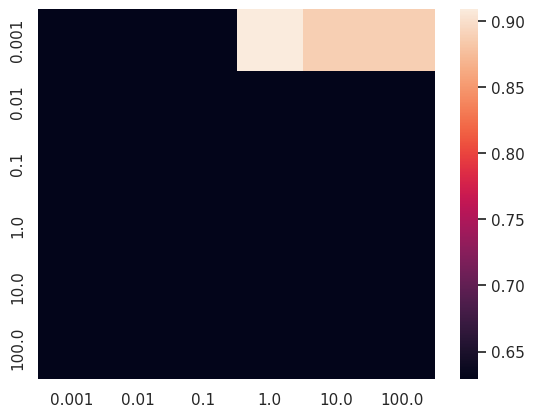

In [ ]:
# インポート
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, stratify = y_cancer, random_state=0)

# ハイパーパラメータに代入して探索したい値の配列データを作成
    # (ここでは一例としてnp.logspace関数を使って対数スケールで配列を作成しているが、この関数を覚えずにlist型のベタ打ちで指定しても問題ない)
    # (下記引数の意味：10の｢-3｣乗から10の｢2｣乗までの範囲から｢6｣つの数値を生成 -> [0.001, 0.01, 0.1, 1, 10, 100])
params_values = np.logspace(-3, 2, num=6)

# ハイパーパラメータのすべての組み合わせでモデルを構築・検証
scores = {}
for gamma in params_values:  # 予め作成しておいた値をfor文で順番に変数`gamma`に代入
    for C in params_values:  # 予め作成しておいた値をfor文で順番に変数`C`に代入
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train,y_train)
        # 各ハイパーパラメータの組合せでのスコアをdict型変数のscoresに記録
        # svmなどほとんどのsklearnの
        scores[(gamma, C)] = svm.score(X_test, y_test)

# forループを回し終えたあと、変数`scores`をdict型からpandas.Series型に変換
# （この箇所以下は結果解説用コードのため、細かい実装内容は覚えなくてOK）
scores = pd.Series(scores)

# 表示
print(f'ベストスコア:{scores.max():.2f}')
print(f'その時のパラメータ(gamma, C):{scores.idxmax()}')

# ヒートマップを表示。縦軸にgamma、横軸にCを表示
sns.heatmap(scores.unstack())

この結果から、ベストスコアは0.91、その時のパラメータは、gammaが0.001、Cが1.0であることがわかります。

#### モジュールの関数を使ってグリッドサーチする

グリッドサーチの仕組みが分かったところで、`sklearn.model_selection`モジュールの`GridSearchCV`クラスを用いて、同等の処理をする方法を説明します。プログラムは、次に示す通りです。

モデル評価用にテストデータを分離するところまでは先程と同様です。違うのは、学習用データを`GridSearchCV`クラスの`fit`メソッドに与えるところです。こうすることで、ハイパーパラメータの組み合わせについてモデルの評価が行われるだけでなく、ベストモデルの構築まで終了します。ベストモデルを実現するパラメータの組み合わせや評価結果は、属性値から取得できます。

ここで留意したいのは、`GridSearchCV`クラスの`fit`メソッドの実行時に行われるモデルの評価は、デフォルトではk分割交差検証（厳密にはその改良版）が使われるという点です。そのため`GridSearchCV`クラスには初期化パラメータ`cv`があり、ここでは`cv=5`と設定しました。

In [ ]:
# インポート
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# GridSearchCVクラスに与えるパラメータを定義したdict型変数を先に作っておく
param_grid = {'C': np.logspace(-3, 2, num=6),
              'gamma':np.logspace(-3, 2, num=6)}

# GridSearchCVクラスの初期化
gs = GridSearchCV(estimator=SVC(),  # グリッドサーチを行いたいモデルを引数`estimator`に指定（ここではサポートベクターマシンの例）
                  param_grid=param_grid,  # この引数に上記で作ったdictを指定する
                  cv=5)  # 何分割で交差検証を行うかを指定

# ハイパーパラメータの組み合わせの検証とベストモデルの構築
gs.fit(X_train, y_train)

# 表示
# GridSearchCVにはこのように様々な結果表示系のインスタンス変数が用意されていて便利に利用できる
print(f'Best cross validation score:{gs.best_score_:.3f}')  # グリッドサーチをした結果最も良かったスコアを表示
print(f'Best parameters:{gs.best_params_}')  # ベストスコアを出したハイパーパラメータの組合せを表示
print(f'Test score:{gs.score(X_test,y_test):.3f}')  # ベストスコアを出したハイパーパラメータでテストデータに対してどのようなスコアが出るかを表示

Best cross validation score:0.925
Best parameters:{'C': 1.0, 'gamma': 0.001}
Test score:0.909


3行の出力結果を見ると、上から順に、グリッドサーチによって見つけられたモデルの評価スコア（0.925）、それを与えるハイパーパラメータの組み合わせ、テスト用データにおける評価スコア（0.909）がわかります。

グリッドサーチによって見つけられたモデルの評価スコアとは、ここでは学習用データのk分割交差検証によって得られた評価スコアを意味しますが、これがテスト用データのスコアに近いことから、過学習は生じていないと考えられます。


Scikit-learnではグリッドサーチの他にランダムサーチを行う`RandomizedSearchCV`クラスも用意されています。また、より自動化したハイパーパラメータ探索の手法としてベイズ最適化を活用したアプローチ（Hyperoptなど）もあります。<br>
<br>
以下に、ランダムサーチの簡易な実装例を示します。

In [ ]:
# ランダムサーチを行うためのクラスをインポート
from sklearn.model_selection import RandomizedSearchCV

# ランダムサーチを行うインスタンスを作成
rs = RandomizedSearchCV(estimator=SVC(),  # ランダムサーチを行いたい機械学習モデルを指定
                        param_distributions=param_grid,  # 先に作成したハイパラ探索範囲を指定したdict型変数を指定
                        n_iter=10,  # 何回探索を行うのかを指定
                        scoring='accuracy',  # ランダムサーチで用いる評価指標を任意に指定（これは正解率を指定する例）
                        random_state=0)

rs.fit(X_train, y_train) # ランダムサーチの実行

# 結果表示
print(rs.best_score_)  # 最も良かったスコア
print(rs.best_params_)  # 最も良かったスコアの時のハイパラの組合せ

0.9248700410396717
{'gamma': 0.001, 'C': 100.0}


>**[やってみよう]**
>
>ランダムサーチやOptuna、Hyperoptについて調べてみましょう。

#### <練習問題 2>
乳がんデータに対して、決定木を使ってグリッドサーチと交差検証を実施してください。なお、決定木のパラメータは、木の深さとリーフに含まれるべき最小サンプル数、具体的には、`param_grid = {'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5]}`と設定してください。

In [ ]:
#<練習問題 2>
#WRITE ME

### 2.3 パフォーマンスチューニング：特徴量の扱い
キーワード：バイアスとバリアンスのトレードオフ、特徴量エンジニアリング、特徴選択、特徴抽出、RFE、RFECV

本節では、モデルのパフォーマンスチューニングを考える上で重要となる**特徴量（feature）**の扱いについて、以下２つの視点に立って説明します。

- 学習不足の場合（underfitting）
- 過学習の場合（overfitting）

※補足：なお、ここで説明していることは、「バイアスとバリアンスのトレードオフ」といったような見出しとともに専門書でも紹介されていますので、さらに詳細について知りたい方は、これらのキーワードで調べてみるのもよいでしょう。

#### 学習不足の場合

モデルが過学習はしてないが精度も低い場合、つまり、そもそもの汎化性能が低いケース（underfitting）では、一般的に、特徴量を増やせないかを検討します。具体的には、新しくデータを収集し全く新しい特徴量を追加する、特徴量の計算期間にバリエーションを持たせる、特徴量同士の比率を追加するなどの工夫を凝らすということです。その他、データを水増しする方法などもありますので、興味ある方は調べてみてください。



#### 過学習の場合

過学習が疑われる場合は、上記の学習不足の場合とは逆に、特徴量の数を減らすことを検討するのが一般的です。データ数に対して特徴量の数が多いと汎化誤差の上限が高まるためです。これを次元の呪いと言います。

特徴量の数を削ることを**次元削減（dimension reduction）**と呼びます。次元削減は2つに分類されます。1つは特徴量のサブセットを選択する**特徴選択（feature selection）**、もう1つは元の特徴空間軸を別の空間軸に変換する**特徴抽出（feature extraction）**です。以前学んだ主成分分析（PCA）はこの特徴抽出の基本的手法として広く知られています。前者の特徴選択については、本講座では詳細を割愛しますが、`sklearn.feature_selection`モジュールの`RFE`クラスや`RFECV`クラスで実行することができます。

どのような特徴量を生成するかを検討することを**特徴量エンジニアリング（feature engineering）**と言います。

特徴量エンジニアリングは画像、音声、自然言語、購買履歴などの構造データ、株価などの時系列データといったデータ構造別や、金融、医療、小売、マーケティング、人事、広告、製造といった業種ごとに知見が蓄積されています。現場に蓄積された知見の反映も大切にしましょう。また、次元削減についてはモデルの解釈が優先される場合は特徴選択を基本とするのがよいでしょう。

参考文献集の「特徴量エンジニアリングを学べる書籍」も参考にしてください。

### 2.4 モデルの種類
キーワード：プロファイリングモデル、予測モデル、優良顧客化予測、ブランド購買離反者予測、ブランドスイッチャー予測、新規商品購買者予測、退職者予測、ハイパフォーマー予測

本節ではモデルの種類について説明します。これまではモデル構築の対象となるデータの背景、特にデータ生成期間について、特段の注意を払ってきませんでした。教師あり学習のモデル構築のためには、当然、説明変数と目的変数を準備する必要がありますが、実はこれら変数の定義期間の違いで、モデルの種類を分けることができます。たとえば、『データマイニング手法予測・スコアリング編―営業、マーケティング、CRMのための顧客分析』では、モデルを**プロファイリングモデル**と**予測モデル**の2つに分けています。

プロファイリングモデルは、説明変数と目的変数とで、それぞれ同じ期間のデータで生成するモデルです。たとえば、セールスマンを昨年度の営業成績上位10%とその他の2つに分け、同期間におけるセールスマンごとの各種アクティビティを説明変数とするといったようなケースです。

一方、予測モデルは、説明変数と目的変数で期間が異なるもので、説明変数は目的変数よりも前の期間から生成されたデータを利用してモデル構築するのが普通です。たとえば、社員の入社から12ヶ月間の各種アクティビティを説明変数とし、入社後13～18ヶ月における退職有無を目的変数などとします。セールス＆マーケティングや人事領域におけるさまざまな予測モデル、優良顧客化予測、ブランド購買離反者予測、ブランドスイッチャー予測、新規商品購買者予測、退職者予測、ハイパフォーマー予測などは、基本的には予測モデル型として説明変数と目的変数が設計されます。

その他、予測モデルとしては、株価の予測などのアプローチにも使います。目的変数は未来の情報ですので、モデル構築時の説明変数にその未来の情報を入れて予測しても、意味がないので注意しましょう。

同じ機械学習のアルゴリズムであっても、分析の目的が対象データの探索的理解なのか予測モデル構築なのかで、準備すべきデータの生成が変わることを理解しましょう。

## 3 モデルの評価指標
ゴール：混同行列とROC曲線を理解し、分類モデルの評価指標を説明できるようになる。

次は、モデルを評価する指標について考えます。モデル性能の評価はさまざまな評価指標によって定義できます。本節では、主に分類モデルの評価指標について学びます。具体的には、**適合率（precision）**、**再現率（recall）**、**F1スコア（F1-measure）**、**AUC（Area Under Curve）**について学びます。また、これらの評価指標を理解するために不可欠な**混同行列（confusion matrix）**と**ROC曲線**についても学びます。最後に、回帰アルゴリズムの評価指標について簡単に紹介します。

### 3.1 分類モデルの評価：混同行列と関連指標
キーワード：混同行列、正解率、適合率、再現率、調和平均、F1スコア

モデルの評価については、これまで主に正解率に主眼をおいてきましたが、モデルの性能を測る指標は正解率の他にもさまざまなものが存在します。それらの指標を理解するため、まずは**混同行列（confusion matrix）**を紹介します。

混同行列は分類モデルの評価を考える際の基本となる行列で、モデルの予測値と観測値の関係を表したものです。具体的には以下の図のように4つの区分を持ちます。予測値の正例（positive）、負例（negative）が列に、観測値の正例、負例が行に並んでいます。予測値の値が「positive」または「negative」の名称の元となり、観測値との整合性からtrueまたはfalseに分けられています。


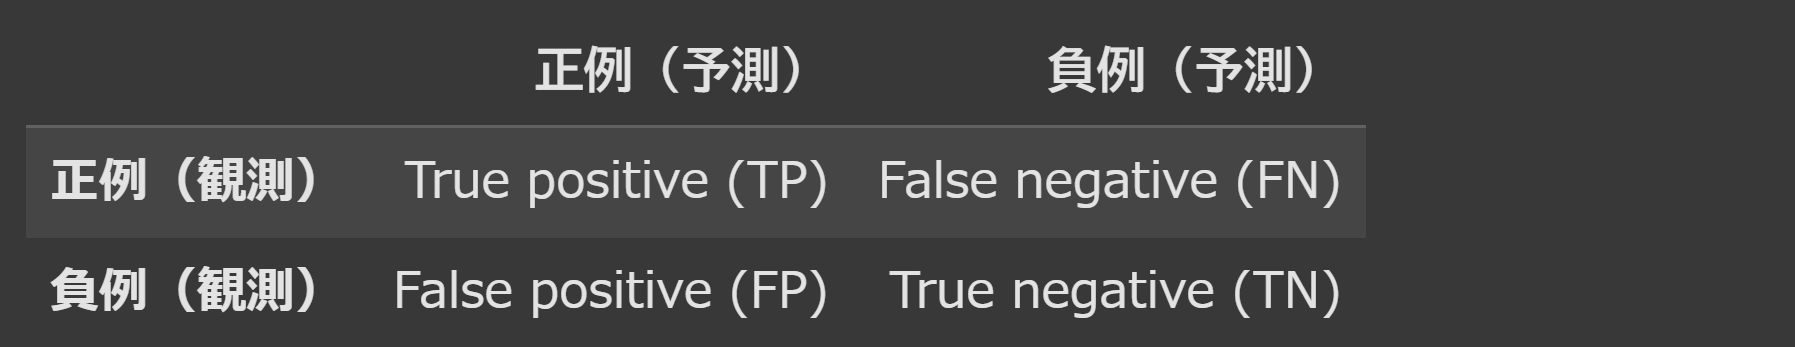


たとえば、予測が正例で実績でも正例ならばTrue positiveになり、予測が負例で実績でも負例ならばTrue negativeになります。この2つのケースは私たちの予測がうまくいったケースとなります。他の場合（False positiveやFalse negative）はうまくいかなかったケースになります。

これだけではわかりにくいので、次に実例をみていきます。

#### 混同行列の実例

以前扱った乳がんデータ（cancerデータ）を使って、混同行列の取得方法を説明します。まずは次のように、サポートベクターマシンとして分類モデルを構築します。この分類モデルは、乳がんであるグループか、そうでないグループかを「0」（malignant/悪性）か「1」（benign/良性）のどちらかの値で返します。なお、0と1は単なるラベルで、数字の大きさに意味はありません。

In [ ]:
# インポート
from sklearn.svm import SVC

# クラスの初期化と学習
model = SVC(gamma=0.001, C=1)
model.fit(X_train, y_train)

# 表示
print(f'SVC train score: {model.score(X_train,y_train):.3f}')
print(f'SVC test score: {model.score(X_test,y_test):.3f}')

SVC train score: 0.981
SVC test score: 0.909



続いて混同行列を取得していきます。混同行列は、`sklearn.metrics`モジュールの`confusion_matrix`関数で取得できます。出力される数値の並びは先の図で記した通り、列に予測値（`y_pred`）、行に観測値（`y_test`）が、正例・負例の順に並びます。

In [ ]:
# インポート
from sklearn.metrics import confusion_matrix

# テストデータを使って予測値を算出
y_pred = model.predict(X_test)

m = confusion_matrix(y_test, y_pred)  #（結果解説用のコードのためこの関数は覚えなくてOK）
print(f'Confution matrix:\n{m}')

Confution matrix:
[[49  4]
 [ 9 81]]


これを表にすると以下のようになります。

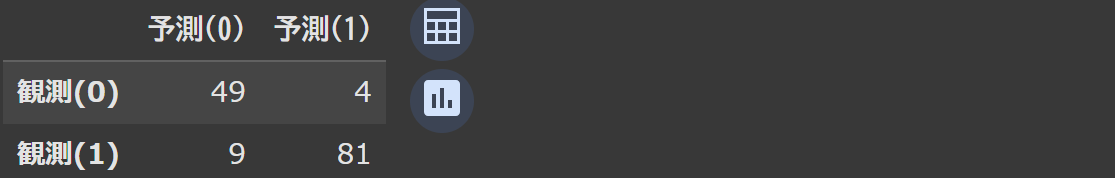

以下、この混同行列を使って、**正解率（accuracy）**、**適合率（precision）**、**再現率（recall）**、**F1スコア（f1 score）**ついて説明します。

#### 正解率

正解率は、全体に対して予測が当たった割合です。これまで正解率はScikit-learnの各クラスの`score`メソッドを使って計算してきましたが、混同行列を使うと以下のように計算できます。`score`メソッドの結果と同じ値になっていることを確認しましょう。

In [ ]:
accuracy = (m[0, 0] + m[1, 1]) / m.sum()
print(f'正解率:{accuracy:.3f}')

正解率:0.909


計算式から分かる通り、目的変数を0と予測して観測値が0であった数（49）と、1と予測して観測値が1であった数（81）の合計（49+81=130）を、行列全体の数（143）で割った値になっています。全体として、どれだけ1と0を正確に予測できているかを見る指標が正解率です。

#### 適合率、再現率、F1スコア

適合率、再現率は、異なる視点からモデルの評価を可能にします。

**適合率 (precision)** は、1と予測した中で実際にどれだけ1であったかの割合です。異常検知システムがアラートを出した回数のうち、実際に異常であった割合などを想像してください。上の例だと1と予測したのは4+81=85で、その中で観測値も1であった数は$81$なので、$81/85$で約$0.953$になります。

**再現率 (recall) / 感度 (sensitivity)** は、実際は1のデータのうち正しく1と予測できた割合です。たとえば、病気の診断システムで再現率100%といった場合は、実際の病気データについてすべて病気であると予測できている状態です。上の例だと1と観測したのは$9+81=90$で、その中での予測値は$82$なので、$81/90$で約$0.900$になります。

**F1スコア**は適合率と再現率の調和平均です。適合率を優先すべきか、再現率を優先すべきかが決まっていない時点で、モデルを総合的に評価する場合などに使われます。なお、調和平均は$2/(1/0.953+1/0.900)$で、約$0.926$になります。なお、調和平均については、統計学の専門書のはじめの方に説明があると思いますので、詳細を知りたい方は調べてみてください。

以上の3指標の算出を混同行列の要素を使って表現すると以下のようになります。

In [ ]:
# 適合率の計算
precision = (m[1, 1]) / m[:, 1].sum()

# 再現率の計算
recall = (m[1, 1]) / m[1, :].sum()

# F1スコアの計算
f1 = 2 * (precision * recall) / (precision + recall)

print(f'適合率:{precision:.3f}')
print(f'再現率:{recall:.3f}')
print(f'F1値:{f1:.3f}')

適合率:0.953
再現率:0.900
F1値:0.926


これらの値は、Scikit-learnの関数を使って求めることもでき、そのほうが簡単です。上記の計算は概念を理解してもらうために1つ1つ計算しましたが、慣れたら以下のようにコーディングしてください。上記と数値が一致していることを確認してください。

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# いずれの関数も第１引数に正解値、第２引数に予測値を格納した変数を指定して使う
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 上記で算出した各スコアを表示
print(f'適合率:{precision:.3f}')
print(f'再現率:{recall:.3f}')
print(f'F1値:{f1:.3f}')

適合率:0.953
再現率:0.900
F1値:0.926


#### <練習問題 3>
<練習問題 2>で使用した乳がんデータに対して、サポートベクターマシン以外のモデル（ロジスティック回帰分析など）を構築し、混同行列を作ってください。また、テストデータにおける正解率、適合率、再現率、F1値の値をScikit-learnの関数を使って取得して下さい。

In [ ]:
#<練習問題 3>
#WRITE ME

### 3.2 分類モデルの評価：ROC曲線とROC-AUC
キーワード：ROC曲線、AUC

前節で学んだ混同行列は、予測結果が正例と負例にラベル付けされていることを前提としますが、モデルの評価時点において、予測ラベルを分ける閾値が事前に決定できるとは限りません。つまり、分類モデルが出力する（予測ラベルではなく）予測確率の値そのものと観測値（1か0か）との関係から、モデルの性能を評価したい場合があり、そのような場合、本節で学ぶ**ROC曲線**と**ROC-AUC**が役に立ちます。

#### ROC曲線

ROC曲線は、縦軸に**真陽性率（tpr: true positive rate）**、横軸に**偽陽性率（fpr: false positive rate）**の値をプロットした曲線です。


真陽性率とは、実際の正例のうちどれだけを正例と予測できたかの割合（再現率と同じ）、偽陽性率とは、実際は負例のうち正例と予測されてしまった割合です。予測確率を予測ラベルに変換する際の閾値を0.0と1.0の間で徐々に変化させ、真陽性率と偽陽性率の関係をプロットすることでROC曲線を描きます。

![comment](https://www.med.osaka-u.ac.jp/pub/kid/image/roc2.gif)


参照URL:(https://www.med.osaka-u.ac.jp/pub/kid/image/roc2.gif)

※縦軸を「真陽性率」として、縦軸を「偽陽性率」としてみてください。

##### 予測確率を閾値で分けて予測ラベルを作る
閾値を変化させてROC曲線を描くとはどういうことか理解するため、乳がんデータを使って確認してみましょう。次のプログラムは、ロジスティック回帰モデルを扱う`LogisticRegression`クラスの`predict_proba`メソッドを使って、がんが悪性（malignant：0）か良性（benign：1）かの予測確率を取得するものです。`predict_proba`メソッドの出力は0か1かのラベルではなく、各クラスに分類される予測確率の配列です。ここでは、悪性（malignant：0）を正例、良性（benign：1）を負例として考えます。

In [ ]:
# インポート
from sklearn.linear_model import LogisticRegression

# LogisticRegressionクラスの初期化と学習
model = LogisticRegression(random_state=0, max_iter=10000)
model.fit(X_train, y_train)

# テスト用データの予測確率を計算
results = pd.DataFrame(model.predict_proba(X_test), columns=cancer.target_names)

# 先頭の5行を表示
results.head()

,malignant,benign
0,0.013384,0.986616
1,0.999982,0.000018
2,0.999994,0.000006
3,0.000374,0.999626
4,0.999538,0.000462


予測確率から予測ラベル分け（「malignant：0」か「benign：1」）するには、単純に50%（0.5）を閾値として、それを超えるかどうかで判断できそうですが、実際はモデルの使用目的、正例の自然発生率などを考慮して閾値を設定します。

閾値を変えれば、当然、良性（正例）と予測されるサンプルの数も変わるので、正解率、適合率、再現率も変わります。たとえば、以下のように、閾値を0.4、0.3、0.15、0.05と4パターンの場合を考えてみます。現在、正例である良性（benign）クラスの予測確率に注目します。以下では、良性の予測確率が閾値を超えていたら1、そうでなければ0となるフラグ変数を作成しています。

In [ ]:
# （概念の解説用コードのため実装内容は覚えなくてOK）

# 良性（benign）クラスの予測確率が0.4、0.3、0.15、0.05以上なら、それぞれの列に1を設定する
for threshold in [0.4, 0.3, 0.15, 0.05]:
    results[f'flag_{threshold}'] = results['benign'].map(lambda x: 1 if x > threshold else 0)

# 先頭の10行を表示
results.head(10)

,malignant,benign,flag_0.4,flag_0.3,flag_0.15,flag_0.05
0,0.013384,9.866163e-01,1,1,1,1
1,0.999982,1.757051e-05,0,0,0,0
2,0.999994,5.850296e-06,0,0,0,0
3,0.000374,9.996261e-01,1,1,1,1
4,0.999538,4.617758e-04,0,0,0,0
5,0.059533,9.404671e-01,1,1,1,1
6,1.000000,1.559470e-19,0,0,0,0
7,1.000000,6.616141e-09,0,0,0,0
8,0.999734,2.659612e-04,0,0,0,0
9,0.009235,9.907647e-01,1,1,1,1


上記の9行目や10行目（インデックス8と9の行）を見ると、予測確率とフラグの関係が理解しやすいと思います。このように、予測確率と閾値から予測フラグを立てることで、観測値との混同行列が作成可能となり、偽陽性率と真陽性率の値を（閾値ごとに）算出できます。

##### ROC曲線をプロットする

上記閾値の4パターンだけではROC曲線のごく一部しか表現できないため、以下では、閾値を0.01から0.99の間で50通りとして、偽陽性率と真陽性率をプロットしてみます。labelsで取得している結果が、上記で確認した予測フラグです。

<Axes: xlabel='false positive rate', ylabel='true positive rate'>

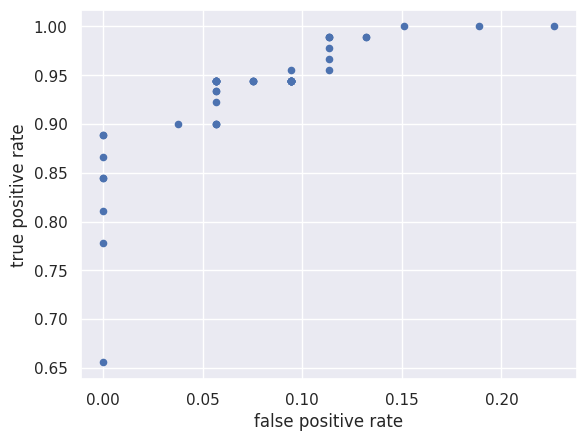

In [ ]:
# （概念の解説用のコードのため実装内容は覚えなくてOK）

# 閾値を0.01から0.99の間で50通りとして、偽陽性率と真陽性率を計算
rates = {}
for threshold in np.linspace(0.01, 0.99, num=50):
    labels = results['benign'].map(lambda x: 1 if x > threshold else 0)
    m = confusion_matrix(y_test, labels)
    rates[threshold] = {'false positive rate': m[0,1] / m[0, :].sum(),
                         'true positive rate': m[1,1] / m[1, :].sum()}

# 横軸をfalse positive rate、縦軸をtrue positive rateとしてプロット
pd.DataFrame(rates).T.plot.scatter('false positive rate', 'true positive rate')

#### ROC曲線とROC-AUC

上ではROC曲線を理解するために、直接プロットしましたが、Scikit-learnのクラスを使っても描画できます。具体的には、`sklearn.metrics`モジュールの`roc_curve`関数を使います。

ここでは同じく乳がんデータを使ってサポートベクターマシンのモデルを構築し、予想確率（`y_pred`）を得ます。

In [ ]:
# インポート
from sklearn import svm
from sklearn.metrics import roc_curve, auc

# SVCによる予測確率の取得
  # (補足：SVCは引数`probability`にTrueを渡しておかないと後で`predict_proba`メソッドが使えないため注意)
model = svm.SVC(kernel='linear', probability=True, random_state=0)
model.fit(X_train, y_train)

# 予測確率を取得
    # (復習事項：`predict`メソッドは 0 または 1 の確定値、`predict_proba`は 0 ~ 1 の間のfloat型で確率値を算出)
    # (`predict_proba`メソッドでは二次元配列が出力され、axis=1のindex0に負例である確率、index1に正例である確率が格納される)
    # (`[:, 1]`の意味：今回取得したいのは正例である確率なのでaxis=1についてindex指定している)
y_pred = model.predict_proba(X_test)[:, 1]

予測確率（`y_pred`）を得たら観測値（`y_test`）と共に`sklearn.metrics`モジュールの`roc_curve`関数に与えます。すると、偽陽性率（fprとする）と真陽性率（tprとする）の各配列を戻り値として取得できるので、それを描画します。実際の計算と描画は次の段落で行います。


##### ROC-AUCの計算

ではROC曲線を計算し、ここではさらにROC-AUCも計算してみます。ROC-AUCの値は`sklearn.metaucs`モジュールの`auc`関数にfprとtprをこの順に与えると取得できます。

ROC曲線は、AUC計算で使ったfprとtprの各配列を使って描画します。赤い実線の下の面積がAUCがそれに相当します。ここでは予測スコアがランダムな場合のROC曲線も合わせて描画しています。黒い点線がそれに相当します。


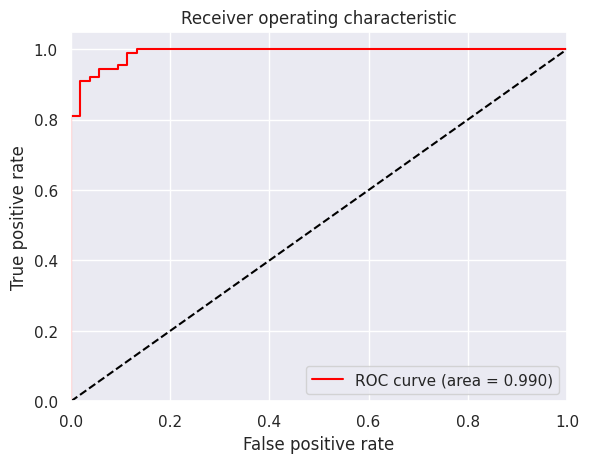

In [ ]:
# （結果解説用のコードのため実装内容は覚えなくてOK）

# 偽陽性率と真陽性率の算出
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# AUCの算出
auc = auc(fpr, tpr)

# ROC曲線の描画
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %.3f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="best")

ここまで、ROC-AUCの性質を理解していただくために詳細な計算過程を示しましたが、正解値と予測値から簡単にこれを求める関数もScikit-learnに提供されています。<br>
考え方が理解できたら、実務ではこちらの方を利用すると便利です。

In [ ]:
# ROC-AUCを直接計算する関数をインポート
from sklearn.metrics import roc_auc_score

# 他のスコア算出系関数と同じく、第一引数に正解値、第二引数に予測値を入力して使用する
roc_auc_score(y_test, y_pred)

0.990146750524109

#### 理想的なROC曲線とAUC

ROC曲線の形状は、閾値を（1.0を超える値から）徐々に小さくしたとき、原点から真陽性率だけが上昇するのが理想です。つまり、原点から座標(0,1)に向けて垂直移動し、その後、座標 (1,1)に水平移動するものが最適理想曲線となります。

逆に、予測確率がランダムな場合、真陽性率も偽陽性率も等しく上昇することが期待されるので、ROC曲線は原点から傾き1の直線となります。機械学習によって構築されたモデルは、通常、ランダムな場合と最適理想曲線の間にプロットされ、より膨らみを持つことが期待されます。

AUCはROC曲線の形状に基づくモデルの評価指標のことで、ROC曲線と横軸で囲まれる面積の値です。つまり、最適理想曲線では1.0、予測確率がランダムな場合は0.5となります。

上記より、本ケースのAUCは0.992であることから、ランダムと比べると、かなり高い性能を有したモデルであると確認できます。ROC曲線やAUCについては『戦略的データサイエンス入門―ビジネスに活かすコンセプトとテクニック』や『Fundamentals of Machine Learning for Predictive Data Analytics: Algorithms, Worked Examples, and Case Studies (MIT Press) 』などが参考になりますので、余裕がある方は読んでみてください。

混同行列の作成、ROC曲線の形状比較、そして適合率、再現率、F1スコア、AUCの大小比較は、モデル選択をする際の基礎的な根拠となります。ただし、あくまでもそれは選択候補のモデル間に、相対的な順番を与えるものに過ぎませんから、モデルを活用したときに得られるであろうビジネス成果との関係を理解することなく、単なる数値追求だけとなることは避けるよう留意しましょう。

#### 不均衡データ下におけるAUCの活用

最後に、AUC活用の意義を補足します。3.2の冒頭では、閾値が不明瞭な段階では混同行列が一意に定まらない点を指摘しました。

AUCを活用すると、不均衡データ（imbalanced data）に対応できます。たとえば、あるスーパーで商品Aを買う人が全体の5%だったとします。予測モデルを構築し、予測確率上位5人が商品Aを買うと予測フラグ立てされるとしましょう。このとき、買うと予測された5人（フラグ1が立っている人）のいずれも正解ではなかった（未購買であった）とします。混同行列に当てはめると以下のようなケースです。全体を100人としています。

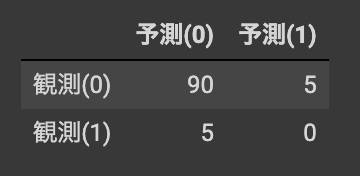

この場合、適合率は0%ですが、正解率は90％となります。もしモデルの精度を正解率だけでみると、90%の正解率は一見良さそうなモデルに見えてしまいます。しかし、予測したい人は買う人ですから、適合率0%のモデルは、意味のあるモデル構築の結果とは言えません。

この例のように「買う人が100人中5人」といった、それぞれのクラスのサンプル数に偏りがある状況下では、正解率は好ましい指標とは言えません。その点、AUCであれば、各クラスのサンプル数の偏りは、fpr（偽陽性率）とtpr（真陽性率）の分母として使われるため吸収されます。つまり、AUCは不均衡データ下におけるモデルの評価時にも耐えられる指標と言えます。

#### <練習問題 4>
以前練習問題で使用したアヤメのデータ（iris）に対して、目的変数をiris.targetとしたSVCを用いた多クラス分類のモデルを作り、そのROC曲線とAUCを計算してください。多クラス分類のモデルを作るには、`sklearn.multiclass`モジュールの`OneVsRestClassifier`クラスを用いてください。

In [ ]:
#<練習問題 4>
#WRITE ME

#### Additionalトピック: loglossについて
分類タスクの評価指標としては、他に主要なものとして`logloss`があります。この資料では詳細な説明は割愛しますが、これは分類モデルが出力する確率と実際のラベルとの間の誤差を測定するための指標として使われるものです。<br>例えば、正解率を使って二値分類モデルの評価をする場合には、分類モデルが (predict_probaメソッドなどを使って) 0.7と予測しても0.9と予測しても、仮に閾値を0.5と定めている場合には等しく`1（正例）`であると予測したことにしてその結果を集計します。しかし、このとき仮に正解が`1（正例）`である場合には、より高い確信をもって0.9と予測したモデルの方が、0.7と予測したモデルよりも高い評価が与えられるべきはずです。正解率ではこのような差異を評価しわけることができませんが、loglossを使った場合にはそれが可能になるなどの利点があります。<br>
loglossも、他の評価指標と同じく[Scikit-learnのライブラリ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)を使うことで簡単に使うことができます。

>**[やってみよう]**
>
>loglossについて調べてみましょう。

### 3.3 回帰モデルの評価指標
キーワード：MSE、MAE、MedAE、R2スコア

前節までは分類モデルの評価指標について学びましたが、本節では回帰モデルの評価指標について紹介します。

回帰モデルは訓練データの目的変数が株価や物件価格などの数値であるため、比較的直感的な指標でモデルを評価することができます。主な評価指標は、以下の通りです。

#### 平均二乗誤差（Mean Squared Error：MSE）
予測値と正解の差（残差）の二乗をサンプルごとに足し上げたものを残差平方和（sum of squared errors：SSE）と言います。そしてそれを最後にサンプル数で割ることで得られるものが平均二乗誤差MSEです。MSEはシンプルでわかりやすい指標のため、さまざまなアルゴリズムの性能評価に使用されます。

#### 平均平方二乗誤差（Root Mean Squared Error：RMSE）
MSEの平方根をとったものです。MSEでは残差を二乗していることからその値は元のデータの尺度と異なるものになっています。このため、尺度を元データと合わせて考察を行いたい場面ではRMSEが用いられます。

#### 平均絶対誤差（Mean Absolute Error：MAE)
残差の絶対値をサンプルごとに足し上げ、最後にサンプル数で割ることで得られるのが平均絶対誤差MAEです。MSEと比べ残差が二乗されていない分、（予測の）外れ値の影響を受けにくいという特徴があります。

#### Median Absolute Error（MedAE）
残差の絶対値の中央値がMedAEです。MAEよりも更に外れ値に堅牢（ロバスト）な評価指標です。

#### 決定係数（$R^{2}$）
決定係数（$R^{2}$）は、検証データの平均値で予測をした場合の残差平方和$SST$（sum of squared total）と、モデルの残差平方和$SSE$（sum of squared errors）の比率で、$R^{2}=1-SSE/SST$と定義されます。平均値予測という最もナイーブな予測に対して二乗誤差をどれだけ削れたかを示す指標で、誤差をすべてなくせば1.0、平均値予測と同等で0.0になります。$R^{2}$の範囲は、通常0〜１の値を取りますが、負になる可能性があることを留意しましょう。

#### 回帰モデルの評価指標の使い分け
大きな予測誤差の存在を重視したいシチュエーションではMSE、そうではなく、平均的な誤差の大きさを重視したいときにはMAEを用います。MSEを使う場面において、元のデータの尺度で誤差を捉えたい時にはRMSEを使うと良いでしょう。MedAEはMSEやMAEと比べるとやや見かけることの少ない指標ですが、MAE以上に徹底的に誤差の外れ値を無視したい事情がある場合には選択肢になりえます。ただし、この場合にはMAEやMSEも併せて確認するのが良いでしょう。<br>
$R^{2}$はモデルがそのデータセットに対してどれだけの説明力を持っているのかを把握したい場合や、異なるデータセット間での難度の比較を行いたい場合などに便利です。<br>
なお、評価指標は無理にどれか１つだけに絞って使う必要はないため、複数の評価指標を同時に算出して総合的にモデル評価することも多いです。

#### 回帰モデル評価の実例

それでは回帰用のサンプルデータセットであるHousingデータセットを使って、回帰モデルにおける評価指標の利用方法を見ていきましょう。

Housingデータセットは、カリフォルニアの地区ブロックごとの特徴量（世帯あたり平均部屋数や収入中央値等）と住宅価格（10万ドル単位）の中央値（`MedHouseVal`）を変数として持っています。データの先頭5行を表示した結果は、次の通りです。

In [ ]:
from sklearn.datasets import fetch_california_housing

# カリフォルニア住宅価格データセットを読み込み（回帰タスク用）
california_housing = fetch_california_housing(as_frame=True)

# 説明変数と目的変数をそれぞれリネーム
    # （※冒頭で扱った乳がんデータ`cancer`と区別するため、`_housing`のサフィックスをつけている）
X_housing = california_housing.data
y_housing = california_housing.target

# 説明変数と目的変数を結合して先頭5行を表示
pd.concat([X_housing, y_housing], axis=1).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


以下では、この`MedHouseValを目的変数`として「重回帰モデル（LinearRegression）」「リッジ回帰モデル（Ridge）」「決定木（回帰木）モデル（DecisionTreeRegressor）」「線形サポートベクター回帰（LinearSVR）」でモデルを構築し、それぞれのモデルに対してMAE、MSE、MedAE、R2の各評価値を算出するプログラムです。評価にはホールドアウト法を採用しました。

In [ ]:
# インポート
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    X_housing, y_housing, test_size=0.5, random_state=0)

# 線形回帰モデルは標準化しないと決定木より不利になるため、標準化処理を行う
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

# モデルの設定
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=0),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'LinearSVR': LinearSVR(random_state=0, max_iter=10000)
}

# 評価値の計算
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # いずれの関数も第１引数に正解値、第２引数に予測値を指定して使う
    scores[(model_name, 'MSE')] = mean_squared_error(y_test, y_pred)
    scores[(model_name, 'MAE')] = mean_absolute_error(y_test, y_pred)
    scores[(model_name, 'MedAE')] = median_absolute_error(y_test, y_pred)
    scores[(model_name, 'R2')] = r2_score(y_test, y_pred)

#表示（※結果解説用）
pd.Series(scores).unstack()

,MAE,MSE,MedAE,R2
DecisionTreeRegressor,0.486836,0.563154,0.289500,0.579518
LinearRegression,0.533041,0.534010,0.414231,0.601279
LinearSVR,0.518601,3.430819,0.343333,-1.561637
Ridge,0.533038,0.534025,0.414267,0.601268


上記の結果より、MAEとMedAEでは決定木が優れますが、MSEとR2スコアでは線形回帰モデルとリッジ回帰モデルが優る結果となりました。<br>
このことから、多くのレコードに対しては決定木がより正確な予測を行えた一方、線形回帰モデルに比べて大外しをしてしまったレコードもあったことが推察できます。<br>
線形サポートベクター回帰はR2スコアがマイナスとなっていることから、もし利用する場合にはハイパーパラメータをデフォルト値から大きく変更して調整する必要がありそうです。
<br><br>
なお上記では、ホールドアウト法において評価指標を取得していますが、もちろん交差検証においても各評価指標を取得することができます。k分割交差検証の場合は、それを行うための`cross_val_score`関数にある引数`scoring`を設定することで戻り値を変更できます。詳しくはScikit-learnの公式ドキュメントを確認してください。

### Additionalトピック: より丁寧なモデル検証に向けて
ここまで様々な評価指標について紹介してきましたが、より丁寧にモデル検証するにあたっては、評価指標だけ確認して終わりにせず直接正解値と予測値をプロットして観察してみることも重要なことです。例えば次のように線形回帰モデルと決定木モデルのカリフォルニア不動産価格予測結果について、X軸に予測値、Y軸に正解値を配してプロットしてみましょう。

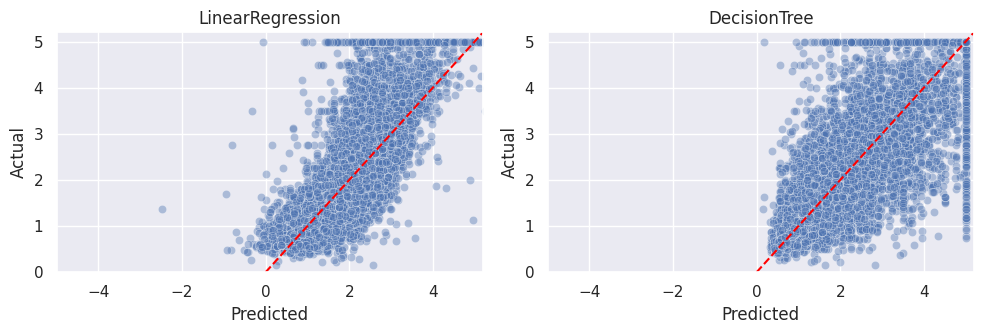

In [ ]:
# (結果解説用のコードのため細かい実装内容は覚えなくてOK)

# (繰り返し実行する可視化のロジックを先に関数で定義)
def plot_pred_vs_actual(model, title):
    """予測値と正解値の散布図をプロットする関数

    Args:
        model (BaseEstimator): 予測値の描画を行うモデル
        title (str): グラフタイトルに表示する文字列
    """

    # (X軸に予測値、Y軸に正解値を配置)
    y_pred = model.predict(X_test)
    sns.scatterplot(x=y_pred, y=y_test, alpha=0.4)
    # (予測値と正解値が一致した場合を参考用に赤い点線で表示)
    plt.plot([0, 10], [0, 10], color='red', linestyle='dashed')
    # (グラフのパラメータを設定)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xlim(-5, 5.2)
    plt.ylim(0, 5.2)


# モデルの作成とトレーニング
linear = LinearRegression().fit(X_train, y_train)
tree = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)

plt.figure(figsize=(10, 3.5))

# Linear Regressionのグラフ
plt.subplot(1, 2, 1)
plot_pred_vs_actual(linear, 'LinearRegression')  # 上記で定義した関数を実行

# Decision Tree Regressorのグラフ
plt.subplot(1, 2, 2)
plot_pred_vs_actual(tree, 'DecisionTree')  # 上記で定義した関数を実行

# グラフの表示
plt.tight_layout()
plt.show()

>**[やってみよう]**
>
>- 上記２つのモデルの結果を観察して、どのようなことに気づきますか？平均値や中央値を用いる評価指標を眺めるだけでは分からない個別の問題が見えてくるはずです。どのような傾向があると言えるか考察してみましょう。<br>
>- 第2回コンペのデータを使って上記と同じようなプロットを作成し、モデル予測の傾向について検証してみましょう。

## 4 アンサンブル学習
ゴール：アンサンブル学習の概要を理解し、代表的手法（ランダムフォレスト、勾配ブースティング）を使えるようになる

これまでに教師あり学習のさまざまなアルゴリズム（決定木、ロジスティック回帰、サポートベクターマシンなど）を個別に学びましたが、ここでは複数のモデルを組み合わせて予測する**アンサンブル学習（ensemble learning）**について学びます。具体的には**バギング（bagging）**、**ブースティング（boosting）**について学びます。またバギングとブースティングの中でも代表的なアルゴリズムとして**ランダムフォレスト（Random Forest）**と**勾配ブースティング（Gradient Boosting）**について学びます。

個別のアルゴリズムのチューニングでは突破できない性能を、アンサンブル学習では実現できる可能性があります。精度追求が重要な局面においてアンサンブル学習は重要な1つのオプションとなり得ます。アンサンブル学習の例えとして、「3人寄れば文殊の知恵」ということがよく言われ、そのイメージです。

### 4.1 バギング
キーワード：バギング、復元抽出、ブートストラップ

**バギング（bootstrap aggregating: bagging）**は、まず元の学習データ（$n$行）からランダムに$n$行のデータを復元抽出（重複を許して抽出）し、新しい学習データを作成するということを繰り返します（ブートストラップと言います）。

そして、その取り出したデータそれぞれに対して、一つ一つモデルを作成し、モデルの結果を集約して予測をします。結果の集約は分類であれば多数決、回帰であれば平均値を取るなどします。元の学習データと少しずつ異なる学習データに対してモデルが構築されるので、モデルが過学習傾向にある時、バギングによって汎化性能を向上させられる可能性があります。以下の図がイメージしやすいです。なお、学習器とは、今まで扱ってきたk-NNなどになります。

![comment](https://image.slidesharecdn.com/random-120310022555-phpapp02/95/-14-728.jpg?cb=1331347003)

参照URL:https://image.slidesharecdn.com/random-120310022555-phpapp02/95/-14-728.jpg?cb=1331347003

#### バギングの実例

以下がバギングの実行例になります。乳がんのデータを使ってk-NNモデルでバギングしてモデルを構築する例です。`sklearn.ensemble`モジュールの`BaggingClassifier`クラスを使っています。なお、回帰用のクラスもあるので、そちらについてはScikit-learnの公式ドキュメントを確認ください。

In [ ]:
# インポート
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    X_cancer, y_cancer, stratify=y_cancer, random_state=66)

# k-NNモデルとそのバギングの設定
models = {
    'kNN': KNeighborsClassifier(),
    'bagging': BaggingClassifier(KNeighborsClassifier(), n_estimators=100, random_state=0)
}

# モデルの構築
# （結果解説用のコードのため細かい実装内容は覚えなくてOK）
scores = pd.DataFrame(columns=["train_score", "test_score"], index=models.keys())
for i, (model_name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    # Scikit-learnの回帰モデルでは`.score`メソッドで引数に渡した説明変数と目的変数に対するR2スコアを算出できる
    scores["train_score"][i] = model.score(X_train, y_train)
    scores["test_score"][i] = model.score(X_test, y_test)

scores

<ipython-input-27-46958b194eb5>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  scores["train_score"][i] = model.score(X_train, y_train)
<ipython-input-27-46958b194eb5>:21: FutureWarning: Series.__setitem__ treating keys as positions is de

,train_score,test_score
kNN,0.948357,0.923077
bagging,0.950704,0.937063


上記では引数`n_estimators`を100として、k-NNのモデルを100個でバギングしています。訓練スコア（`train_score`）の値はほぼ同等ですが、テストスコア（`test_score`）の値が上昇していることを確認できます。

`BaggingClassifier`クラスは他に`max_samples`（デフォルトは1.0）、`max_features`（デフォルトは1.0）というパラメータを持ちます。前者はブートストラップをする時に元のデータの何割抽出するかを指定します。0.5とすれば元の訓練データが100件あれば50件の標本が抽出されます。後者は説明変数をどの程度サンプリングするかの指定で、0.5とすれば全変数のうちの半分でモデルが学習されます。

元のモデルが過学習しているときは、手元のデータをそのまますべて使わないようにし、説明変数に（標本ごとに）多様性を与えることで、有効な過学習対策になる可能性があることを覚えておきましょう。

>**[やってみよう]**
>
>BaggingClassifierのパラメータについて調べてみましょう。

#### <練習問題 5>
アヤメのデータセットを対象にバギングを使って、目的変数（`iris.target`）を予測するモデルを構築し検証しましょう。また、パラメータとして何を調整しますか。調べて実行してみましょう。

In [ ]:
#<練習問題 5>
#WRITE ME

### 4.2 ブースティング
キーワード：ブースティング、アダブースト

前節のバギングでは、ブートストラップによって抽出された複数の標本に対して（個別に）複数のモデルが構築されます。一方、本節で学ぶ**ブースティング（boosting）**は、学習データもモデルも逐次的に生成・構築されていきます。

もう少し詳細に述べると、まずオリジナルの学習データに対し最初のモデルが構築されます。この時点で予測と正解を比較して合致しているサンプル、外しているサンプルを把握します。そして外したサンプルが、次のモデル構築の段階で重視されるように新しい学習データが生成されます。このようなステップが繰り返される過程でモデルも逐次的に複数構築されるのです。最後に、それらの予測値を組み合わせることで精度向上が図られます。なお、ブースティングは学習不足（underfitting）傾向の時に効果的な手法と言われています。

下記に、参照URLを載せます。順番に（逐次的に）モデルを構築しているイメージです。

![comment](https://cdn-ak.f.st-hatena.com/images/fotolife/S/St_Hakky/20170728/20170728171209.jpg)

参照URL：https://cdn-ak.f.st-hatena.com/images/fotolife/S/St_Hakky/20170728/20170728171209.jpg

#### ブースティングの実例

ブースティングの実例を示します。決定木モデル（DecisionTreeRegressor）をブースティングするものです。ブースティングには、`sklearn.ensemble`モジュールの`AdaBoostRegressor`クラスを使います。ブースティングのアルゴリズムには、他にLPBoost、BrownBoost、LogitBoostなどがありますので、興味のある方は「ブースティング」やこれらのキーワードで調べてみてください。

In [ ]:
# インポート
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    X_housing, y_housing, random_state=66)

# 決定木とAdaBoostRegressorのパラメータ設定
models = {
    'tree': DecisionTreeRegressor(random_state=0),
    # 引数`estimator`にベースモデルを指定する。ここでは決定木を指定しているが他のものでもOK
    'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=0)
}

# モデル構築
# （結果解説用のコードのため細かい実装内容は覚えなくてOK）
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

# 結果を表示（R2スコア）
pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.821205,0.999373
tree,0.613043,1.000000


決定木を単体で使う場合のテストスコアは約0.61止まりですが、AdaBoostRegressorクラスを使ったアンサンブル学習に切り替えるとテストスコアが約0.82と大きく向上していることがわかります。このようにアンサンブル学習は精度追求局面においては大変強力なオプションになり得ることを覚えておきましょう。

ただし今回のアダブーストの結果は、やや過学習傾向にある点（学習データとテストデータとのスコアにやや乖離がある）は留意すべきでしょう。

>**[やってみよう]**
>
>AdaBoostRegressorのパラメータについて調べてみましょう。上の過学習を防ぐために、どうやってパラメータを設定しますか。

#### <練習問題 6>
アヤメのデータセットを対象にブースティング（`AdaBoostRegressor`クラス）を使って、目的変数（`iris.target`）を予測するモデルを構築し検証しましょう。また、パラメータとして何を調整しますか。調べて実行してみましょう。

In [ ]:
#<練習問題 6>
#WRITE ME

### 4.3 ランダムフォレスト、勾配ブースティング
キーワード：ランダムフォレスト、勾配ブースティング、変数の重要度、Partial Dependence Plots

本節では、バギングとブースティングの中でも代表的なものである**ランダムフォレスト（Random Forest）**と**勾配ブースティング（Gradient Boosting）**の使い方を紹介します。いずれも、ベースとしているアルゴリズムは決定木です。

アンサンブル学習を手軽に実行する場合、上記のいずれかのアルゴリズムが採用されるケースが多いです。機械学習の初学者であれば、考え方を3.1と3.2で理解し、実際のモデル構築はこれらのアルゴリズムで行うというスタートが良いと思われます。

またモデル結果の解釈性が優先される場合は、ロジスティック回帰や決定木など、よりシンプルなモデルを採用した方が良い局面もあることは留意しておきましょう。

#### ランダムフォレストと勾配ブースティングの実例

実際にランダムフォレストと勾配ブースティングを使ったプログラム例を見てみましょう。データはHousingデータを使いました。

In [ ]:
# インポート
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(
    X_housing, y_housing, random_state=66)

# ランダムフォレストと勾配ブースティングのパラメータ設定
models = {
    'RandomForest': RandomForestRegressor(random_state=0),
    'GradientBoost': GradientBoostingRegressor(random_state=0)
}

# モデル構築
scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

# 結果を表示（R2スコア）
pd.Series(scores).unstack()

,test_score,train_score
GradientBoost,0.795131,0.808224
RandomForest,0.812549,0.972619


#### 変数の重要度

上記の結果から、Housingデータに対しては、ランダムフォレストの性能が高そうであることがわかります。

先に、アンサンブル学習のモデルの解釈性（の低さ）について言及しましたが、モデル構築の中でどの変数が重要な役割を担ったかを定量的に把握することができます。具体的には各オブジェクトが持つ`feature_importmnces`属性にアクセスすることで、**変数の重要度（feature importance）**を取得することができます。実際に取得すると、次のようになります。

<Axes: >

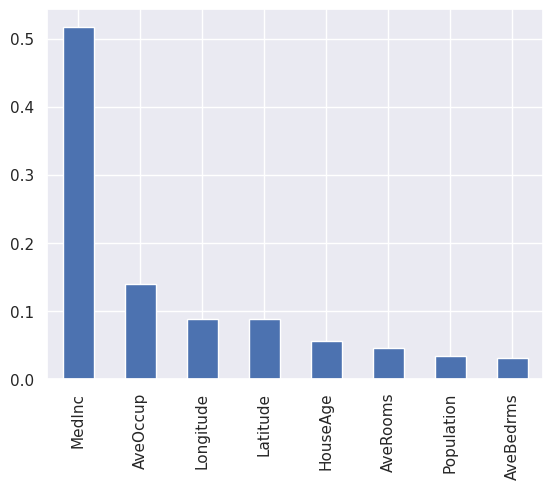

In [ ]:
# feature_importmnces属性を取得
s = pd.Series(models['RandomForest'].feature_importances_,
              index=X_housing.columns)

# 取得した値を降順に表示
s.sort_values(ascending=False).plot.bar(color='C0')

参考まで、今回サンプルデータとして利用しているHousingデータはインスタンス変数`DESCR`にアクセスすることで各カラム名の意味するところを閲覧することができますから、これを表示してみます。<br>
下記をみると、地区ブロックごとの収入中央値が最も特徴量重要度が高く、世帯ごとの平均人数などがそれに続く結果となりました。

In [ ]:
# Scikit-learnのサンプルデータはインスタンス変数としてデータセットに関する説明文が含まれている
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

変数の重要度は、以前登場した情報利得をベースに計算されています。そのため変数の重要度を見ても回帰係数のような解釈は困難です。ただし、相対的な大小関係から、どの変数がモデル構築において重要であったかは示してくれますし、この変数が効果的であろうという直感と整合的な結果になることも少なくありませんから、確認する癖を付けておくことは大切です。

また、重要変数に絞り、説明変数と目的変数の関係を深堀りすれば、それがなぜモデル構築に役立ったか考察することもできます。

本講座では割愛しますが、Partial Dependence Plots（PDP）という、説明変数の大小と予測値の大小関係性を図解してくれる関数も存在します。Scikit-learnでは`plot_partial_dependence`関数が用意されていますので、更に理解を深めたい方は[公式ドキュメント](https://scikit-learn.org/stable/modules/ensemble.html)を参照ください。

#### Additionalトピック: Scikit-learn以外の高度な勾配ブースティング専用ライブラリ
勾配ブースティングツリーは数ある数値予測系の機械学習モデルの中で最も精度追求に適している側面があるため、Scikit-learn以外にも様々なライブラリで高性能化したものが提供されています。<br>
有名なものとしては`XGBoost`や`LightGBM`、`CatBoost`などが`kaggle`などのコンペティションプラットフォームで頻繁に利用されます。<br>
ここではXGBoostの実装例を示します。なお、XGBoostには独自のインターフェイスの他にScikit-learnと同じ使用方法を再現したインターフェイスが用意されており、下記に示すのは後者の方になります。

In [ ]:
# XGBoostのインポート (Scikit-learnではないことに留意)
from xgboost import XGBRegressor

# XGBoostのインスタンスを作成
reg = XGBRegressor(n_estimators=100, random_state=0)
reg.fit(X_train, y_train) # 学習
y_pred = reg.predict(X_test) # 予測

# 結果を表示（R2スコア）
print(f"Test score: {r2_score(y_test, y_pred): .3f}")

Test score:  0.841


`XGBoost`にはScikit-learnの勾配ブースティングモデル以上に様々な便利機能が提供されています。ここではその一例として、検証スコアが指定したラウンド数改善されない場合、ブースティングを早期終了させる設定ができる`early_stopping_rounds`を使ってみましょう。

In [ ]:
# このコードセルを実行すると何行も出力されるため、GoogleColabの表示行数を縮める設定を行います（この２行は覚えなくてOK）
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# X_trainとy_trainを更に分割し、訓練データと検証データを用意
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# ブースティングの回数を先ほどの10倍の回数(1000)に設定
# early_stopping_roundsを使わずにブースティング数だけ増やすと精度向上の可能性と同時に過学習のリスクが高まる
reg = XGBRegressor(n_estimators=1000,
                   eval_metric='rmse',  # 早期終了の判断基準とする評価指標を指定(ここではMSEの平方根をとったRMSEという指標)
                   early_stopping_rounds=10,  # 何ラウンド改善が見られなければブースティングを打ち切りとするかをここで指定
                   random_state=0)

reg.fit(X_train_split, y_train_split,
        eval_set=[(X_valid, y_valid)])  # eval_setに検証用データを指定

# 上記の指定の結果、1回ブースティングを行うたびに検証データでRMSEによるスコアリングを内部で実施し、20回改善がなければ早期終了する

y_pred = reg.predict(X_test) # 予測

# 結果を表示（R2スコア）
print(f"Test score: {r2_score(y_test, y_pred): .3f}")

<IPython.core.display.Javascript object>

[0]	validation_0-rmse:0.94717
[1]	validation_0-rmse:0.81703
[2]	validation_0-rmse:0.72572
[3]	validation_0-rmse:0.66901
[4]	validation_0-rmse:0.62957
[5]	validation_0-rmse:0.60705
[6]	validation_0-rmse:0.57592
[7]	validation_0-rmse:0.56336
[8]	validation_0-rmse:0.55473
[9]	validation_0-rmse:0.54597
[10]	validation_0-rmse:0.53373
[11]	validation_0-rmse:0.52897
[12]	validation_0-rmse:0.52469
[13]	validation_0-rmse:0.51497
[14]	validation_0-rmse:0.51249
[15]	validation_0-rmse:0.50899
[16]	validation_0-rmse:0.50840
[17]	validation_0-rmse:0.50599
[18]	validation_0-rmse:0.50594
[19]	validation_0-rmse:0.50454
[20]	validation_0-rmse:0.50134
[21]	validation_0-rmse:0.49902
[22]	validation_0-rmse:0.49710
[23]	validation_0-rmse:0.49486
[24]	validation_0-rmse:0.49426
[25]	validation_0-rmse:0.49314
[26]	validation_0-rmse:0.49289
[27]	validation_0-rmse:0.49175
[28]	validation_0-rmse:0.49112
[29]	validation_0-rmse:0.49032
[30]	validation_0-rmse:0.48861
[31]	validation_0-rmse:0.48844
[32]	validation_0-

どのように出力されたでしょうか。今回のデータセットの場合、early_stopping_roundsの利用によっては特段精度向上には繋がらなかったかもしれません。データセットごとに適するハイパーパラメータの組合せは異なりますから、高度なハイパーパラメータを試したものの結果に結びつかないということはよくあることです。ただし、多くの場合、初手においては過学習を抑制する方向に寄せたハイパーパラメータで着手し、徐々にそれを緩めるという進め方をする方が好ましいです。<br>
教材で用いる軽量なサンプルデータではどうしても説明変数と目的変数の関係性が単純なものになるため過学習が問題となりにくいですが、より複雑なデータでは事情が変わってきます。GCIで開催する第2回コンペのデータはより複雑なデータになっていますから、ぜひこちらでも試してみましょう。

>**[やってみよう]**
>
>- `XGBoost`のハイパーパラメータについて調べてみましょう。過学習を防ぐために、`early_stopping_rounds`の他にどのようなハイパーパラメータが用意されていますか。<br>
>- `XGBoost`は`GPU`を使って高速化する設定が可能です。それはどのようにすることで利用できるでしょうか。
<br>
>- 余力があれば`LightGBM`についても調べてみましょう。`XGBoost`とどのような違いがありますか。
>- 今回紹介したアンサンブル手法の他に、有名なものとしては`Stacking（スタッキング）`と呼ばれる手法があります。スタッキングでは複数の異なるモデルの予測結果を特徴量として学習した「メタモデル」を構築して最終的な予測を作成する手法です。コンペで上位を狙う方はこちらについても調べてみましょう。

#### Additionalトピック: アンサンブル手法の使い分け

ハイパーパラメータの設定方法にもよるため一概には断定できませんが、一般的には過学習を防ぐ必要性が高く、予測の安定性を求めたい場面ではバギングが適します。これに対し、ある程度過学習のリスクがあっても高い精度追求をしたいシチュエーションではブースティングが強力な選択肢となるでしょう。<br>
ただし、XGBoostなどのライブラリには過学習を防止し、汎化性能を高める利便性の高いハイパーパラメータも用意されているため、これらを使いこなすことでブースティングでも安定性を重視したモデル構築は可能です。前述したGPUを使った高速化の利点は実運用においては非常に大きいことから、XGBoostやLightGBMの方が、ランダムフォレストなどよりも最終的なモデルとしては採用される傾向が強いです。<br>
スタッキングはバギングやブースティングと排他的な選択肢ではないためコンペティションなどでの競技的な精度追求の最終局面では広く選好されますが、安定性や説明性にデメリットが生じるため、実運用において幅広くみられる手法ではありません。<br>
また、説明性が最も重要なユースケースでは、そもそもアンサンブルを用いず、線形モデルなどのよりシンプルなモデルを使うことも多いです。

### 4.4　今後の学習に向けて
最後に、今後の学習のための参考書を紹介します。具体的な書籍情報は参考文献集「さらに機械学習を理解したい方向けの書籍」にまとめています。後半は少し難易度が高い機械学習の本で、より理論的な知識や実装を身につけたい方にオススメです。ある程度数学的なバックグランドも必要ですが、本講座を終えた後であれば大丈夫だと思います。

「さらに機械学習を理解したい方向けの書籍」はどちらかというと比較的数式が多く、あまりビジネス的な視点では多くは書かれていません。『戦略的データサイエンス入門―ビジネスに活かすコンセプトとテクニック』は、ビジネスでデータサイエンスを活かす視点で記載されていますので、ぜひ参考にしてください。

#### <練習問題 7>
アヤメのデータを対象にランダムフォレストと勾配ブースティングを使って、目的変数（`iris.target`）を予測するモデルを構築し検証しましょう。また、パラメータとして何を調整しますか。調べて実行してみましょう。

In [ ]:
#<練習問題 7>
#WRITE ME

## 5 総合問題

### ■総合問題 1 教師あり学習の用語（2）

以下の用語について、それぞれの役割やその意味について述べてください。
- 過学習
- ホールドアウト法
- 交差検証法
- グリッドサーチ
- 特徴量
- 特徴選択
- 特徴抽出
- 混同行列
- ROC曲線
- 適合率
- 再現率
- 正解率
- F1スコア
- 真陽性率（True Positive Rate）
- 偽陽性率（False Positive Rate）
- AUC
- ブートストラップ法
- アンサンブル学習
- バギング
- ブースティング
- ランダムフォレスト

### ■総合問題 2 交差検証

乳がんデータセットを使って、予測モデル（ロジスティック回帰、SVM、決定木、k-NN、ランダムフォレスト、勾配ブースティング）を構築し交差検証（5分割）により、どのモデルが一番良いか確認してください。

In [ ]:
#<総合問題 2>
#WRITE ME

**謝辞**：以下のデータセットの利用に関して利用に関して
1. http://lib.stat.cmu.edu/datasets/boston

引用元：The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978. Used in Belsley, Kuh & Welsch, 'Regression Diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980.